In [1]:
# https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier

In [18]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
model_filename = "../../models/corrected_baseline.joblib"
model = joblib.load(model_filename)

In [4]:
len(model.feature_names_)

94

In [5]:
feature_importance = model.feature_importances_
selected_feature_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 20, 22, 24, 29, 32, 34, 42, 50, 52, 60, 63, 64, 65, 70, 71, 72, 73, 74, 75, 76, 77, 85, 89, 90, 93]
string_selected_list = [str(s) for s in selected_feature_names]
feature_names = model.feature_names_
data = {'feature_names':feature_names,'feature_importance':feature_importance}
impt_df = pd.DataFrame(data)

In [6]:
impt_df.reset_index()

,index,feature_names,feature_importance
0,0,0,4.515856
1,1,1,0.811960
2,2,2,1.482546
3,3,3,0.545977
4,4,4,3.143033
...,...,...,...
89,89,89,1.192107
90,90,90,3.098776
91,91,91,0.234850
92,92,92,0.512581


In [7]:
def build_lookup_list(start, end):
    range_list = [*range(start,(end+1),1)]
    range_list = [str(s) for s in range_list]
    return range_list

In [8]:
dem_feat = 0
s1_feat = ['1', '2']
s2_feat = build_lookup_list(3, 12)
TTC_feat = build_lookup_list(13, 77)
tex_blue_feat = build_lookup_list(78, 81)
tex_green_feat = build_lookup_list(82, 85)
tex_red_feat = build_lookup_list(86, 89)
tex_nir_feat = build_lookup_list(90, 93)

In [9]:
impt_df['category'] = 'na'
impt_df.loc[impt_df['feature_names'] == '0', 'category'] = 'DEM'
impt_df.loc[np.isin(impt_df['feature_names'], s1_feat), 'category'] = 'Sentinel 1'
impt_df.loc[np.isin(impt_df['feature_names'], s2_feat), 'category'] = 'Sentinel 2'
impt_df.loc[np.isin(impt_df['feature_names'], TTC_feat), 'category'] = 'TTC'
impt_df.loc[np.isin(impt_df['feature_names'], tex_blue_feat), 'category'] = 'Texture (blue band)'
impt_df.loc[np.isin(impt_df['feature_names'], tex_green_feat), 'category'] = 'Texture (green band)'
impt_df.loc[np.isin(impt_df['feature_names'], tex_red_feat), 'category'] = 'Texture (red band)'
impt_df.loc[np.isin(impt_df['feature_names'], tex_nir_feat), 'category'] = 'Texture (NIR band)'

In [10]:
impt_df['selected'] = False
impt_df.loc[np.isin(impt_df['feature_names'], string_selected_list), 'selected'] = True


In [11]:
impt_df

,feature_names,feature_importance,category,selected
0,0,4.515856,DEM,True
1,1,0.811960,Sentinel 1,True
2,2,1.482546,Sentinel 1,True
3,3,0.545977,Sentinel 2,True
4,4,3.143033,Sentinel 2,True
...,...,...,...,...
89,89,1.192107,Texture (red band),True
90,90,3.098776,Texture (NIR band),True
91,91,0.234850,Texture (NIR band),False
92,92,0.512581,Texture (NIR band),False


In [14]:
impt_df.sort_values(['category', 'feature_importance'], ascending=False, inplace=True)
impt_df = impt_df.astype({"feature_importance":float, "feature_names": str})
impt_df= impt_df.sort_values(by=['feature_importance'], ascending=False)
impt_df

,feature_names,feature_importance,category,selected
13,13,23.168618,TTC,True
65,65,5.106402,TTC,True
0,0,4.515856,DEM,True
12,12,3.772906,Sentinel 2,True
4,4,3.143033,Sentinel 2,True
...,...,...,...,...
16,16,0.036069,TTC,False
56,56,0.034076,TTC,False
43,43,0.031412,TTC,False
69,69,0.024891,TTC,False


In [16]:
impt_df.to_csv("../../data/figures/feat_selection_data.csv")

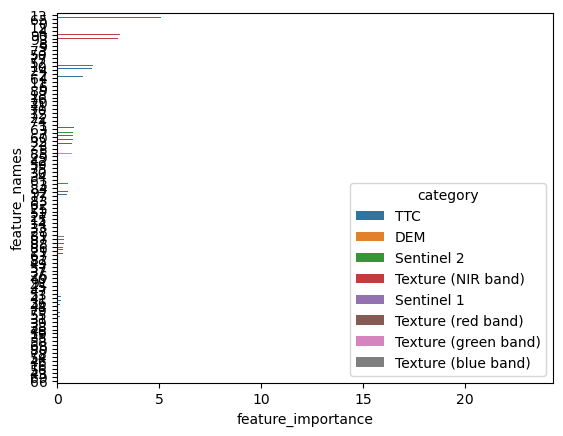

In [15]:
# sns.set_theme(rc={'figure.figsize':(10,16)})
sns.barplot(data=impt_df, y = 'feature_names', x='feature_importance', hue='category');

In [21]:
impt_df[:15]

,feature_names,feature_importance,category,selected
13,13,23.168618,TTC,True
65,65,5.106402,TTC,True
0,0,4.515856,DEM,True
12,12,3.772906,Sentinel 2,True
4,4,3.143033,Sentinel 2,True
90,90,3.098776,Texture (NIR band),True
93,93,2.990906,Texture (NIR band),True
8,8,2.707242,Sentinel 2,True
9,9,2.491512,Sentinel 2,True
73,73,2.208570,TTC,True


<Axes: xlabel='feature_importance', ylabel='category'>

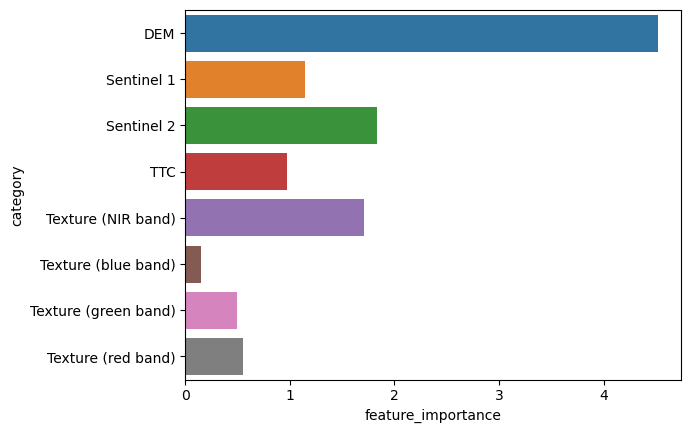

In [63]:
mean_importance = pd.DataFrame(impt_df.groupby('category')['feature_importance'].mean()).reset_index()
mean_importance
sns.barplot(data=mean_importance, y = 'category', x='feature_importance', hue='category')

In [22]:
total_counts = impt_df.groupby('category')['feature_importance'].count()
total_counts

category
DEM                      1
Sentinel 1               2
Sentinel 2              10
TTC                     65
Texture (NIR band)       4
Texture (blue band)      4
Texture (green band)     4
Texture (red band)       4
Name: feature_importance, dtype: int64

In [23]:
selected_counts = impt_df[impt_df['selected'] == True].groupby('category')['feature_importance'].count()
selected_counts

category
DEM                      1
Sentinel 1               2
Sentinel 2              10
TTC                     23
Texture (NIR band)       2
Texture (green band)     1
Texture (red band)       1
Name: feature_importance, dtype: int64

In [24]:
percent_selected = pd.DataFrame((selected_counts / total_counts) * 100).reset_index()
percent_selected['percent_selected'] = percent_selected['feature_importance'].fillna(0)
percent_selected

,category,feature_importance,percent_selected
0,DEM,100.000000,100.000000
1,Sentinel 1,100.000000,100.000000
2,Sentinel 2,100.000000,100.000000
3,TTC,35.384615,35.384615
4,Texture (NIR band),50.000000,50.000000
5,Texture (blue band),NaN,0.000000
6,Texture (green band),25.000000,25.000000
7,Texture (red band),25.000000,25.000000


<AxesSubplot: xlabel='percent_selected', ylabel='category'>

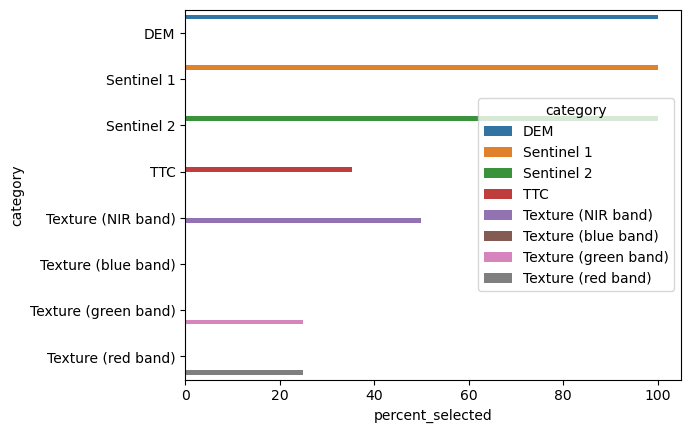

In [25]:
sns.barplot(data=percent_selected, y = 'category', x='percent_selected', hue='category')

<AxesSubplot: xlabel='feature_importance', ylabel='feature_names'>

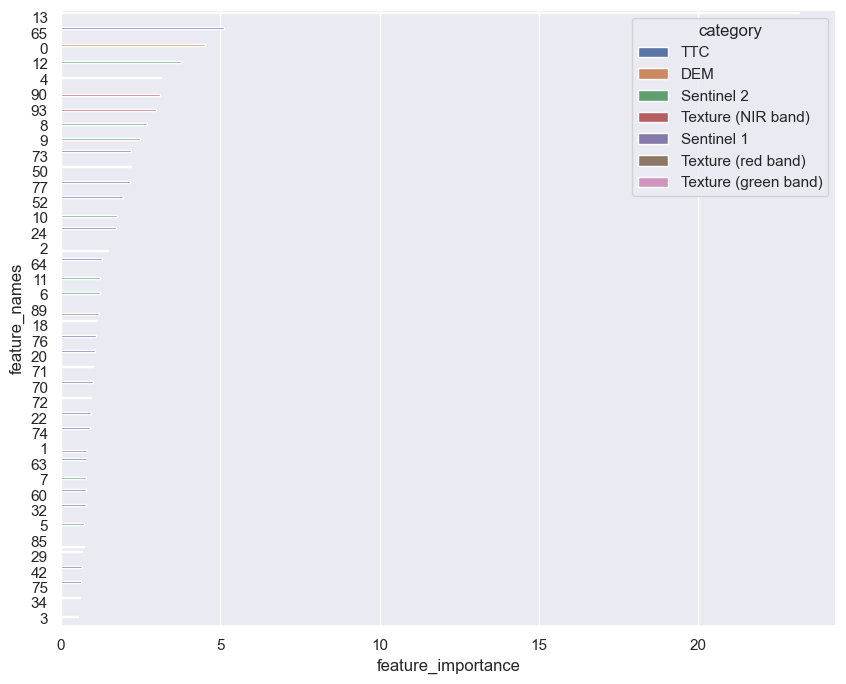

In [26]:
selected_only = impt_df[impt_df['selected'] == True].sort_values(by=['feature_importance'], ascending =False)

sns.set_theme(rc={'figure.figsize':(10,8)})
sns.barplot(data=selected_only, y = 'feature_names', x='feature_importance', hue='category')

In [50]:
def plot_feature_imp(df: pd.DataFrame, figsize: tuple = (8, 10)):
    """
    Plots a horizontal bar chart of selected features by their importance scores using matplotlib.

    Parameters:
    - df (pd.DataFrame): DataFrame containing 'feature_names', 'feature_importance', 'category', and 'selected' columns.
    - figsize (tuple): Size of the figure (width, height).
    """

    # Filter to selected features only and sort
    df_selected = df[df["selected"] == True].copy()
    df_selected = df_selected.sort_values(by="feature_importance", ascending=True)

    # Update TTC label to 'Extracted Tree Features'
    df_selected["category"] = df_selected["category"].replace({"TTC": "Extracted Features"})

    # Define an updated color palette
    palette = {
        "Sentinel 2": "#3182bd",                    # cool blue
        "Sentinel 1": "#9e9ac8",                    # muted purple
        "Extracted Features": "#006d2c",       # deep green
        "DEM": "#fe8266",                           # light orange
        "Texture (green band)": "#4daf4a",          # more distinct green
        "Texture (red band)": "#d73027",            # dark red
        "Texture (NIR band)": "#fdb863"             # warm yellow-orange
    }

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    y_pos = range(len(df_selected))
    colors = [palette.get(cat, "#cccccc") for cat in df_selected['category']]

    bars = ax.barh(
        y=y_pos,
        width=df_selected['feature_importance'],
        color=colors,
    )

    # Axis settings
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_selected['feature_names'])
    ax.set_xlabel("Feature Importance Score")
    ax.set_ylabel("Feature Indices")
    ax.set_title("Feature Importance Scores for Selected Features", pad=10)

    # Remove grid background and reduce white space
    ax.grid(False)
    ax.set_ylim(-0.5, len(df_selected) - 0.5)

    # Add legend manually
    unique_cats = df_selected["category"].unique()
    handles = [plt.Rectangle((0, 0), 1, 1, color=palette[cat]) for cat in unique_cats]
    ax.legend(handles, unique_cats, title="Feature Source", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


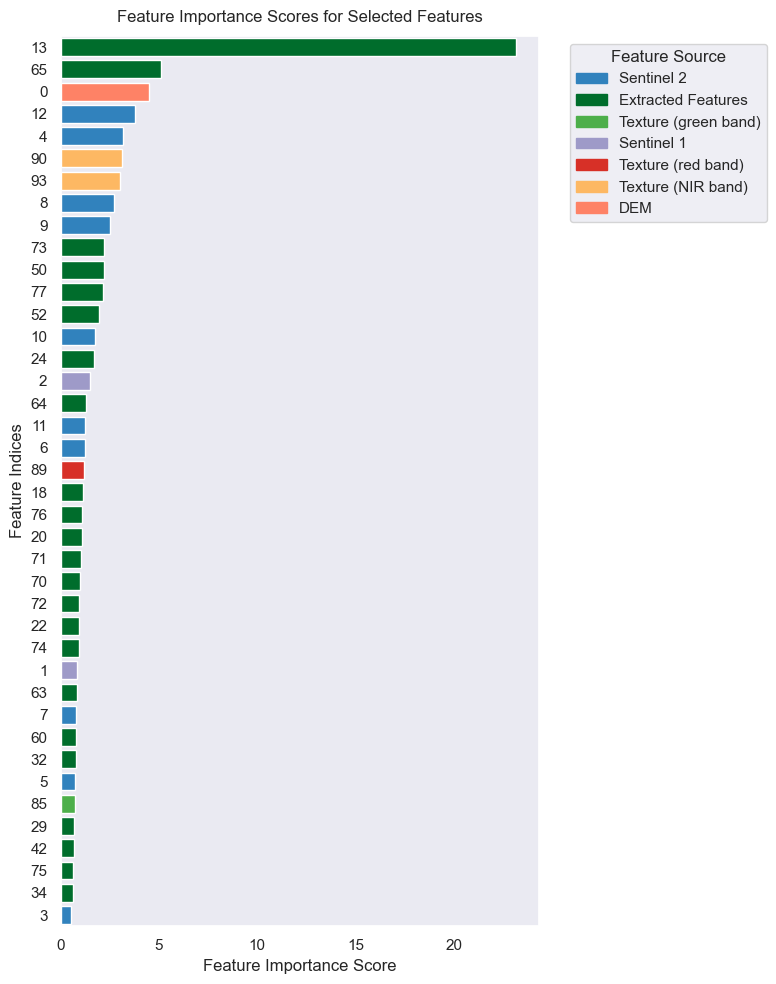

In [51]:
plot_feature_imp(impt_df, figsize=(8, 10))